# Time Series Analysis & Forecasting

Here some methods in TSA/F are explored and utilized

It requires that there are directories of csv files in /data containing all of the data that should be used.

In [1]:
# Imports
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Read in data
years = ["2019", "2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("./data/2018_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"./data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()

Data Collected


,ISO Time,Temperature (C),Humidity (%),Pressure (kPa),Air Quality (Ohms)
0,2018-01-01 00:00:02,19.60,44.49,99.436,12946860.0
1,2018-01-01 00:01:02,19.61,44.46,99.435,12946860.0
2,2018-01-01 00:02:01,19.62,44.46,99.433,12946860.0
3,2018-01-01 00:03:02,19.63,44.39,99.425,12946860.0
4,2018-01-01 00:04:02,19.62,44.39,99.433,12946860.0


### General Preprocessing

In [3]:
# Preprocessing

# Convert to date time
all_data['ISO Time'] = pd.to_datetime(all_data['ISO Time'])
all_data.set_index('ISO Time')

# Assurance that there are datapoints from each year -- This may throw an error as more is added to the code base
assert list(all_data['ISO Time'].dt.year.unique()) == [2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Number of observations
len(all_data)

print(all_data.head())

             ISO Time  Temperature (C)  Humidity (%)  Pressure (kPa)  \
0 2018-01-01 00:00:02            19.60         44.49          99.436   
1 2018-01-01 00:01:02            19.61         44.46          99.435   
2 2018-01-01 00:02:01            19.62         44.46          99.433   
3 2018-01-01 00:03:02            19.63         44.39          99.425   
4 2018-01-01 00:04:02            19.62         44.39          99.433   

   Air Quality (Ohms)  
0          12946860.0  
1          12946860.0  
2          12946860.0  
3          12946860.0  
4          12946860.0  


### Feature Expansion -- Computation of daily descriptive statistics

In [4]:
grouped_data = all_data.groupby(all_data['ISO Time'].dt.date)

# Temperature Celsius
temperature_stats = grouped_data['Temperature (C)'].agg(
    min='min',
    max='max',
    mean='mean',
    median='median',
    std='std'
)
temperature_stats.index = pd.to_datetime(temperature_stats.index)
temperature_stats = temperature_stats.asfreq('D').interpolate(method='time')
print("Temperature Stats\n")
print("Number of observations", len(temperature_stats))
print(temperature_stats.head())

# Humidity % moisture
humidity_stats = grouped_data['Humidity (%)'].agg(
    min='min',
    max='max',
    mean='mean',
    median='median',
    std='std'
)
humidity_stats.index = pd.to_datetime(humidity_stats.index)
humidity_stats = humidity_stats.asfreq('D').interpolate(method='time')
print("\nHumidity Stats\n")
print("Number of observations", len(humidity_stats))
print(humidity_stats.head())

# Pressure kPa
pressure_stats = grouped_data['Pressure (kPa)'].agg(
    min='min',
    max='max',
    mean='mean',
    median='median',
    std='std'
)
pressure_stats.index = pd.to_datetime(pressure_stats.index)
pressure_stats = pressure_stats.asfreq('D').interpolate(method='time')
print("\nPressure Stats\n")
print("Number of observations", len(pressure_stats))
print(pressure_stats.head())

# Air Quality Ohms
airq_stats = grouped_data['Air Quality (Ohms)'].agg(
    min='min',
    max='max',
    mean='mean',
    median='median',
    std='std'
)
airq_stats.index = pd.to_datetime(airq_stats.index)
airq_stats = airq_stats.asfreq('D').interpolate(method='time')
print("\nAir Quality Stats\n")
print("Number of observations", len(airq_stats))
print(airq_stats.head())

list_of_dataframes = [temperature_stats, humidity_stats, pressure_stats, airq_stats]

Temperature Stats

Number of observations 2557
              min    max       mean  median       std
ISO Time                                             
2018-01-01  16.99  19.66  18.389903   18.34  0.685289
2018-01-02  14.66  17.01  15.835549   15.88  0.580612
2018-01-03  13.56  15.80  14.646667   14.65  0.507629
2018-01-04  13.97  16.85  15.515403   15.58  0.918085
2018-01-05  15.82  18.20  16.903662   17.00  0.367914

Humidity Stats

Number of observations 2557
              min    max       mean  median       std
ISO Time                                             
2018-01-01  32.13  44.49  36.907361  35.135  3.784848
2018-01-02  34.18  46.11  42.534833  43.950  3.395228
2018-01-03  39.87  56.14  48.947486  50.325  5.883896
2018-01-04  48.01  55.65  52.431951  53.550  2.577857
2018-01-05  38.92  50.26  42.455638  40.735  3.551891

Pressure Stats

Number of observations 2557
               min      max        mean    median       std
ISO Time                                       

### Train Test Split

Holds the last year of time series data as the test set

The rest is train

In [5]:
def ts_train_test_split(total_timeseries):
    '''
    Simple fixed test set function that returns the time series split into the final year as test, and all other data as train
    Input: 
        - total_timeseries: the timeseries with at least a year of data and a pandas datetime index
    Output:
        - train: all data from the beginning to a year before the newest date of the total_timeseries
        - test: one year of data, until the newest date of total_timeseries
    Postconditions:
        - The data period of train and test is printed to standard output
    '''
    last_year = total_timeseries.index.year.max()
    test = total_timeseries[total_timeseries.index.year == last_year]
    train = total_timeseries[total_timeseries.index.year < last_year]

    # Print the data period for reassurance
    print(f"Training data period: {train.index.min()} to {train.index.max()}")
    print(f"Test data period: {test.index.min()} to {test.index.max()}")
    return train, test

In [6]:
# Train - Test Split

# Temperature (C) medians (and good test code!)
temp_medians = temperature_stats['median']
last_year = temp_medians.index.year.max()
temperature_medians_test = temp_medians[temp_medians.index.year == last_year]
temperature_medians_train = temp_medians[temp_medians.index.year < last_year]

# Assurance that it is the final year
print(f"Training data period: {temperature_medians_train.index.min()} to {temperature_medians_train.index.max()}")
print(f"Test data period: {temperature_medians_test.index.min()} to {temperature_medians_test.index.max()}")

# Test
test_func_train, test_func_test = ts_train_test_split(temp_medians)
assert test_func_train.equals(temperature_medians_train)
assert test_func_test.equals(temperature_medians_test)

Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


### Time Series Prediction Evaluation Suite

### Contents:
- Plots Predicted vs. Actual with 95% CI
- Plots residuals
- Plots KDE smoothing of residual distribution
- Plots Autocorrelation of residuals
- Returns MAE, MSE, RMSE



In [7]:
def evaluate_ts_predictions(test_actual, test_predictions, name: str):
    '''
    Inputs:
        - test_actual: timeseries of test data with the same index as the predictions
        - test_predictions: timeseries of model predictions
        - name: The name for plotting (also the y-variable or value of the timeseries)
    Returns: 
        - MAE
        - MSE
        - RMSE
    Plots:
        - Plots Predicted vs. Actual with 95% CI
        - Plots residuals
        - Plots KDE smoothing of residual distribution
        - Plots Autocorrelation of residuals
    Prints:
        - MAE
        - MSE
        - RMSE
    '''
    # Get residuals
    residuals = test_actual - test_predictions
    std_residuals = residuals.std()
    
    # Determine CI bounds - (are we just predicting means? "iterated point estimation")
    lower_bound = test_predictions - 1.96*std_residuals
    upper_bound = test_predictions + 1.96*std_residuals
    
    # Plot true against predicted
    plt.figure(figsize=(14,8))
    plt.plot(test_actual.index, test_actual, label="Actual", color="blue", linewidth=2)
    plt.plot(test_actual.index, test_predictions, label="Predicted", color="orange", linestyle="--", linewidth=2)
    
    # Add CI shading
    plt.fill_between(
        test_actual.index,
        lower_bound,
        upper_bound,
        color="orange",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    
    # Plot details
    plt.title(f"Actual vs. Predicted {name} with Confidence Intervals", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    plt.figure(figsize=(12,6))
    plt.plot(test_actual.index, residuals, label="Residuals", color="red")
    plt.axhline(0, linestyle="--", color="black", linewidth=1)
    plt.title("Residuals Over Time")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.legend()
    plt.show()
    
    # Distribution of residuals (ideally normal)
    plt.figure(figsize=(8,6))
    sns.histplot(residuals, kde=True, bins=30, color="purple")
    plt.title("Residuals Distribution (Ideally Approx. Normal)")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()
    
    # Autocorrelation of residuals (ideally 0)
    plot_acf(residuals, lags=30)
    plt.title("Autocorrelation of Residuals (Ideally 0)")
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lags")
    plt.show()
    
    # Produce quantitative metrics
    mae = mean_absolute_error(test_actual, test_predictions)
    mse = mean_squared_error(test_actual, test_predictions)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    return mae, mse, rmse

# Time Series Forecasting Models

Models Examined:
- Auto Regression (AR)
- Auto Regressive Integrated Moving Average (ARIMA)
- Seasonal Auto Regressive Integrated Moving Average (SARIMA)
- Vector Auto Regressive Integrated Moving Average (VARIMA)

Basic workflow:
- define a train and evaluate method
- do HPO CV of whatever hyperparameters there are
- plot best hyperparameter's cv loss plot
- plot loss function w.r.t. different hyperparameters
- evaluate using the plotter method


Note: 

I want to eventually make a robust model that predicts an hourly (or daily) bitcoin price box plot

It should be a VARIMAX model so that it can take multiple market time series and other crypto time series as well as sentiment values of frequently publishing and reputable text sources regarding bitcoin.

It should be a streaming application so, continuously updates with new time series information and journal posts

I think this would teach a lot about data science that they won't really cover in the master's degree 
(or most master's degrees for that matter since it uses too much CS for statisticians and too much Stats for Computer Scientists)


## Auto Regression (AR)

Definition: The current value of the time series depends on its past values.

Mathematical Definition:

$$X_t = c + \phi_1X_{t-1} + \phi_2X_{t-2} + \dots + \phi_{p}X_{t-p} + \varepsilon_t$$

Components:
- $X_t$: Current value of the series.
- $c$: Constant term
- $\phi_1, \phi_2, ..., \phi_p$: AR coefficients
- $p$: Number of lagged terms (order of the AR model)
- $\varepsilon_t$: *White* noise (normally distributed error)

The model uses previous timesteps' values to predict the value of the current one.

The coefficients ($\phi_i$) quantify the relationship between the current and past values

e.g. The daily temperature depends on the previous day's temperature 
-- if it was 0 degrees yesterday, it will probably be near 0 tomorrow.


In [8]:
def train_and_evaluate_ar_model(train, test, name: str, max_lag=20, num_folds=5):
    '''
    Trains, does HPO with CV, and evalutes a auto regression timeseries model given train and test 
    Inputs:
        - train: a train timeseries compatible with TimeSeriesSplit
        - test: a test timeseries
        - name: the y-value of the time series
        - max_lag: maximum lag (hyperparameter of autoregression) to try
        - num_folds: the number of cross validation folds to use
    Outputs:
        - Test MAE
        - Test MSE
        - Test RMSE
    Postconditions:
        - Lags vs. RMSE is plotted
        - The best Lag's RMSE plot is plotted
        - evaluate_ts_predictions is called & plots are produced
    '''
    # Time series cross validation 
    tscv = TimeSeriesSplit(n_splits = num_folds)

    # Lag range, for HPO
    lag_range = range(1, max_lag)
    lag_rmse = []
    best_lag_cv_rmse = []

    for lag in lag_range:
        cv_rmse = []

        for train_index, val_index in tscv.split(train):
            # Train/Val split
            cv_train, cv_val = train[train_index], train[val_index]

            # Create model & fit
            model = AutoReg(cv_train, lags=lag)
            model_fitted = model.fit()

            # Get predictions
            cv_predictions = model_fitted.predict(start=cv_val.index[0], end=cv_val.index[-1])

            # Calculate fold RMSE
            rmse = np.sqrt(mean_squared_error(cv_val, cv_predictions))
            cv_rmse.append(rmse)

        # Store and eval mean RMSE for this run
        mean_rmse = np.mean(cv_rmse)
        lag_rmse.append(np.mean(cv_rmse))

        # Save the cv rmse list of the best lag
        if mean_rmse < max(lag_rmse):
            best_lag_cv_rmse = cv_rmse

    # Find the best lag
    best_lag = lag_range[np.argmin(lag_rmse)]
    print(f"Best Lag: {best_lag}, Validation RMSE: {min(lag_rmse)}")

    # Plot the best lag's CV plot
    plt.plot(range(len(best_lag_cv_rmse)), best_lag_cv_rmse, '.')
    plt.title("CV RMSE")
    plt.ylabel("RMSE")
    plt.xlabel("CV Iteration")
    plt.ylim([min(best_lag_cv_rmse)-np.var(best_lag_cv_rmse), max(best_lag_cv_rmse)+np.var(best_lag_cv_rmse)])
    plt.show()

    # Plot the Total Lag RMSE
    plt.plot(lag_range, lag_rmse)
    plt.title("Lag RMSE plot")
    plt.ylabel("RMSE")
    plt.xlabel("Lag")
    plt.ylim([min(lag_rmse)-np.var(lag_rmse),max(lag_rmse)+np.var(lag_rmse)])
    plt.show()

    # Train and predict with final model
    final_model = AutoReg(train, lags=best_lag).fit()  # Train on train
    test_predictions = final_model.predict(start=test.index[0], end=test.index[-1])

    # Conduct evaluation suite on the predicted time series
    evaluate_ts_predictions(test, test_predictions, name)


#### Use of AR model on daily median weather measurements

Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Best Lag: 7, Validation RMSE: 7.079714174055104


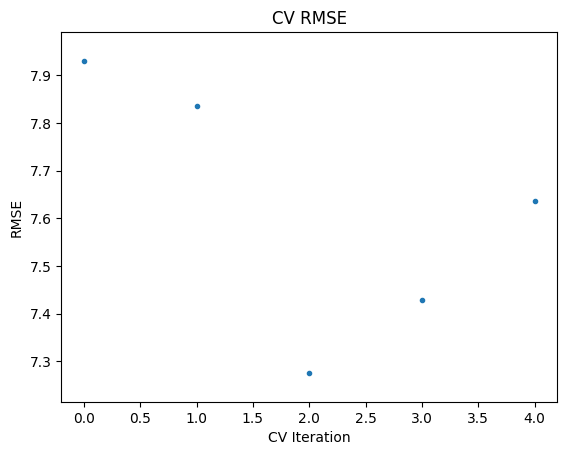

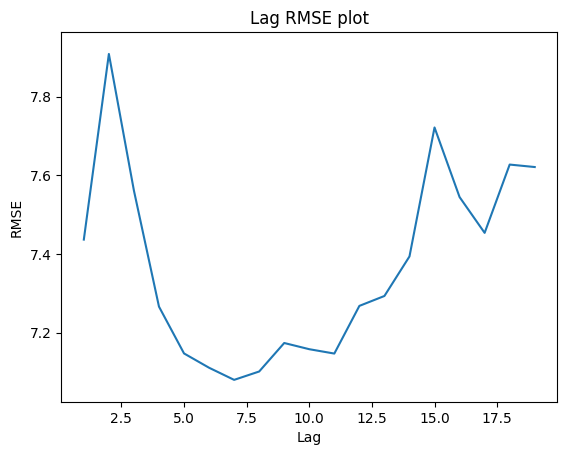

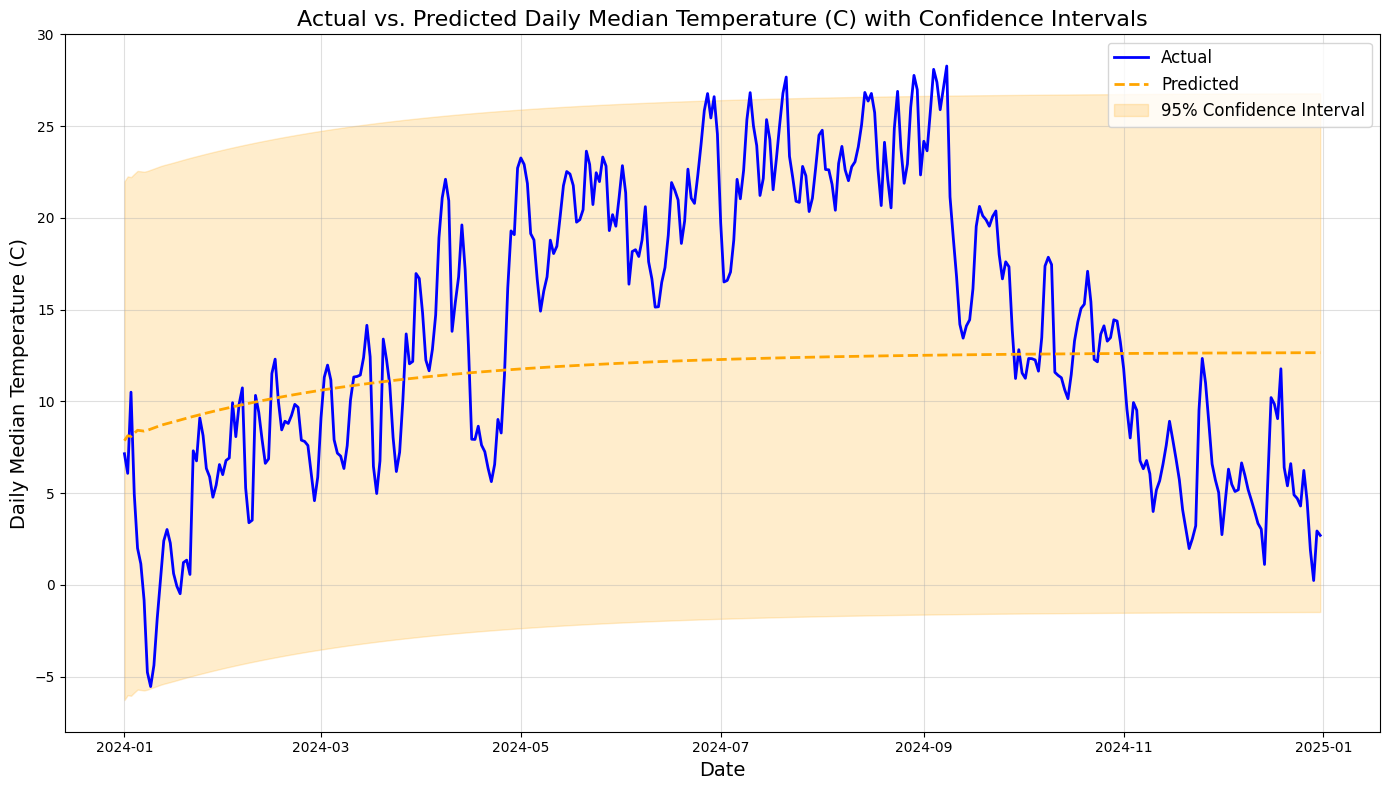

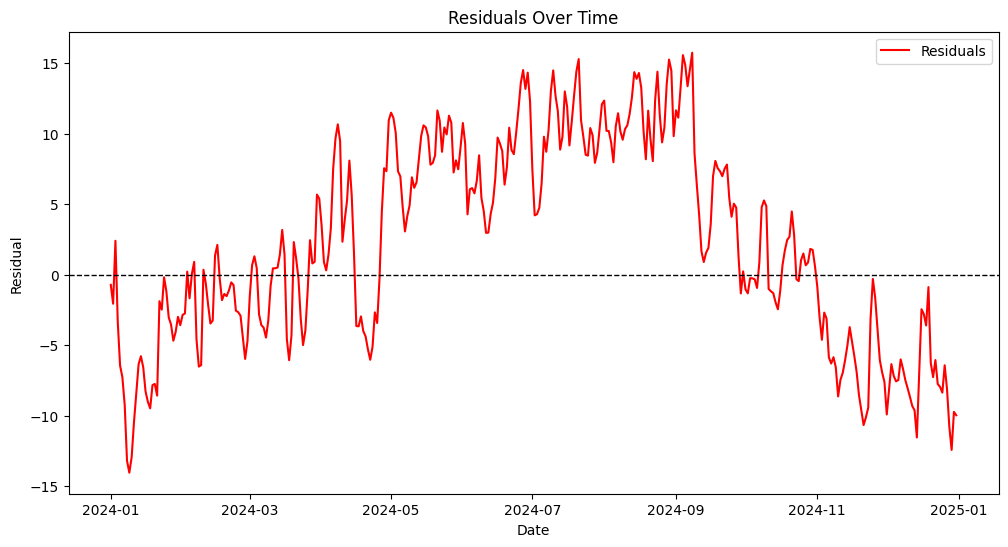

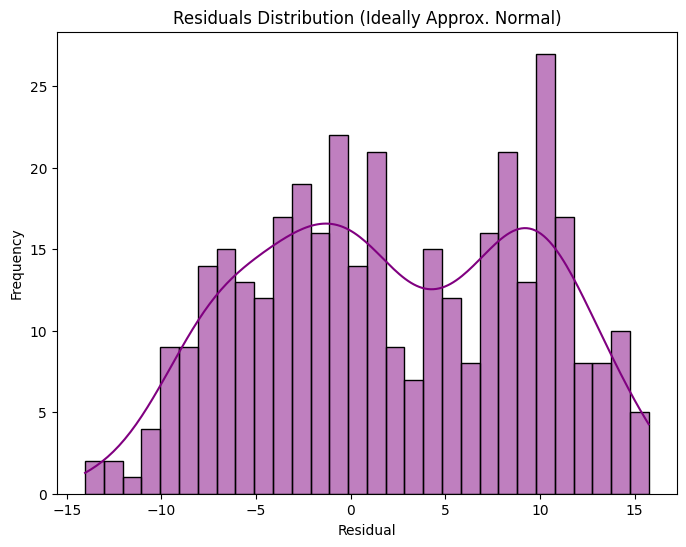

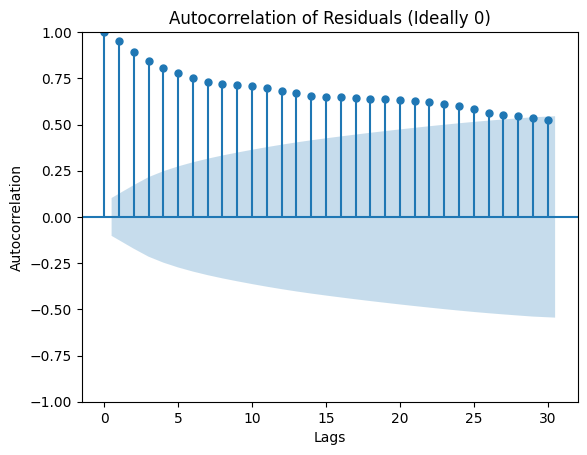

Mean Absolute Error (MAE): 6.35
Mean Squared Error (MSE): 56.73
Root Mean Squared Error (RMSE): 7.53


Forecasting of Humidity
Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Best Lag: 4, Validation RMSE: 18.913292397345394


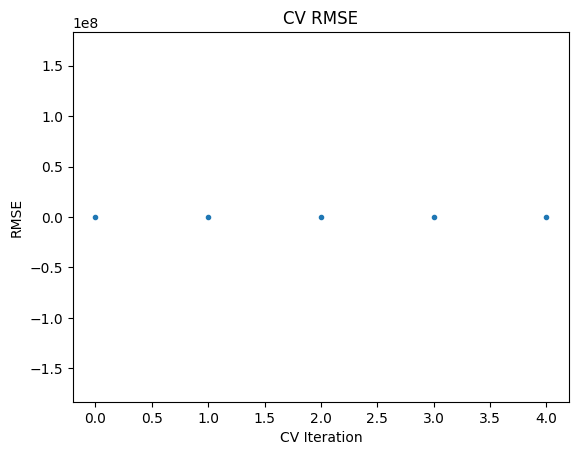

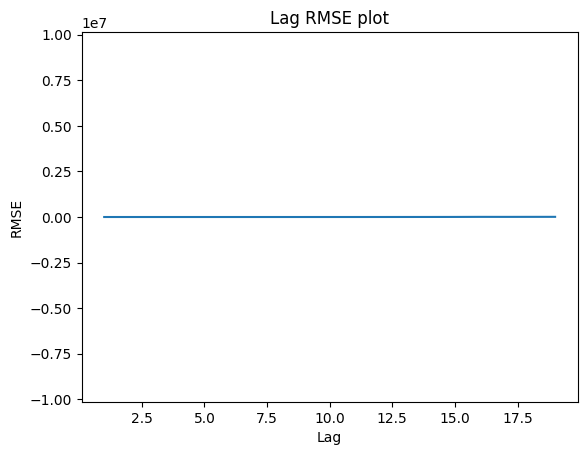

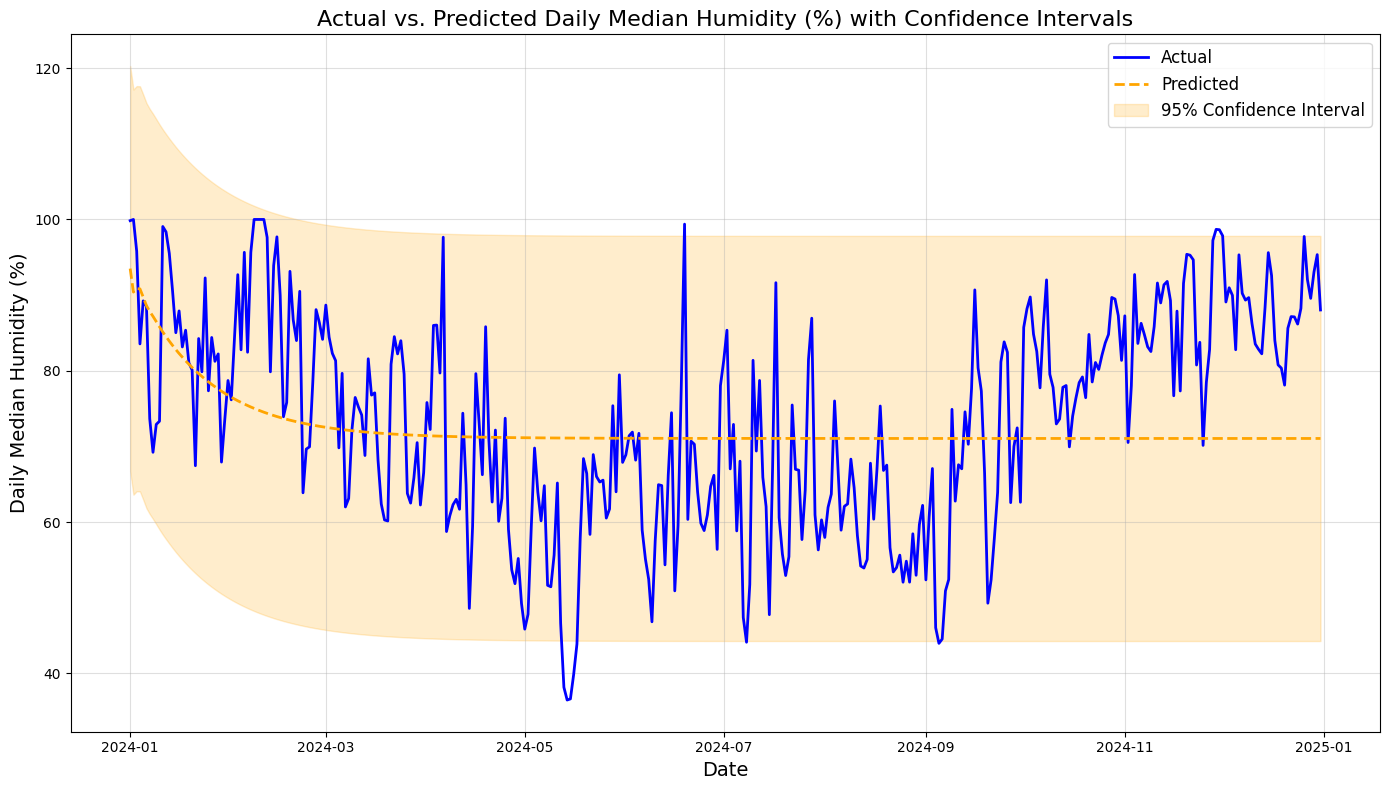

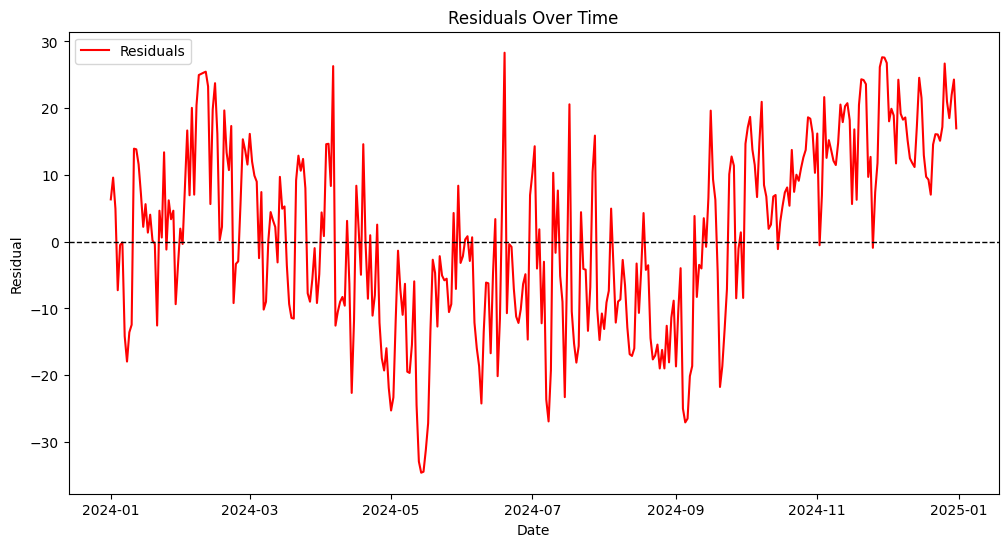

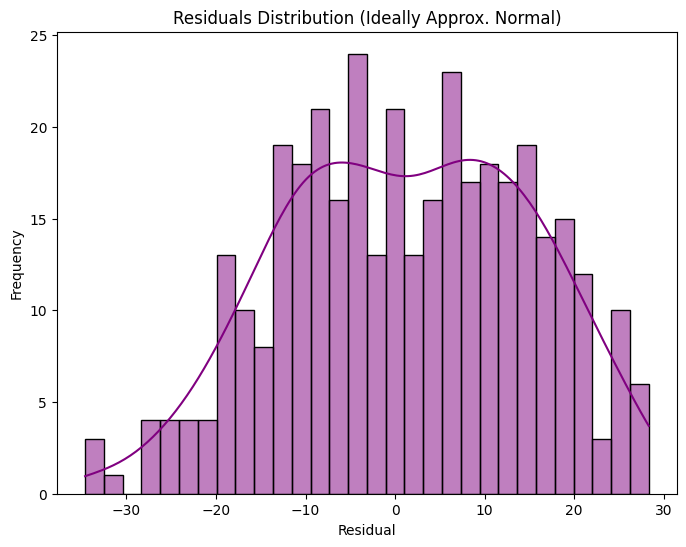

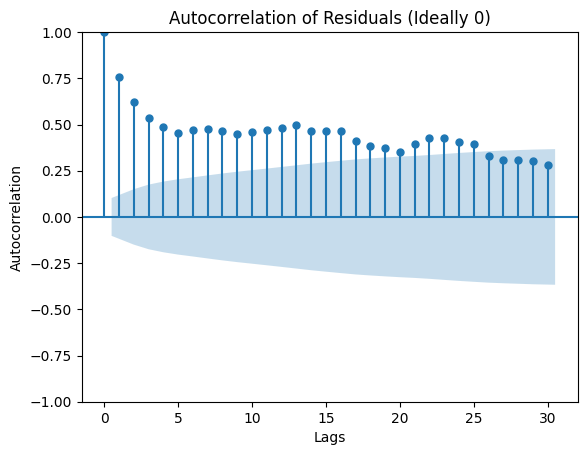

Mean Absolute Error (MAE): 11.51
Mean Squared Error (MSE): 187.34
Root Mean Squared Error (RMSE): 13.69


Forecasting of Pressure
Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Best Lag: 15, Validation RMSE: 1.5365052286925411


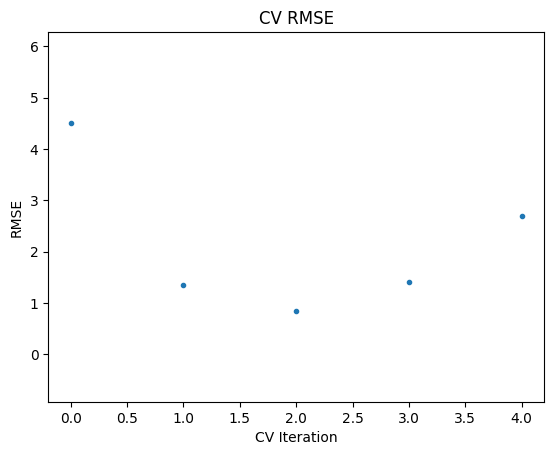

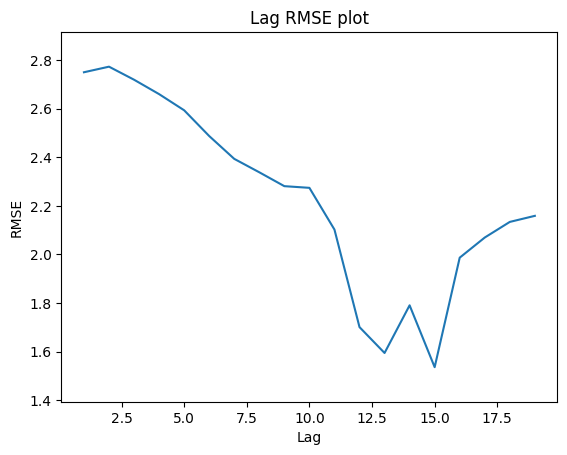

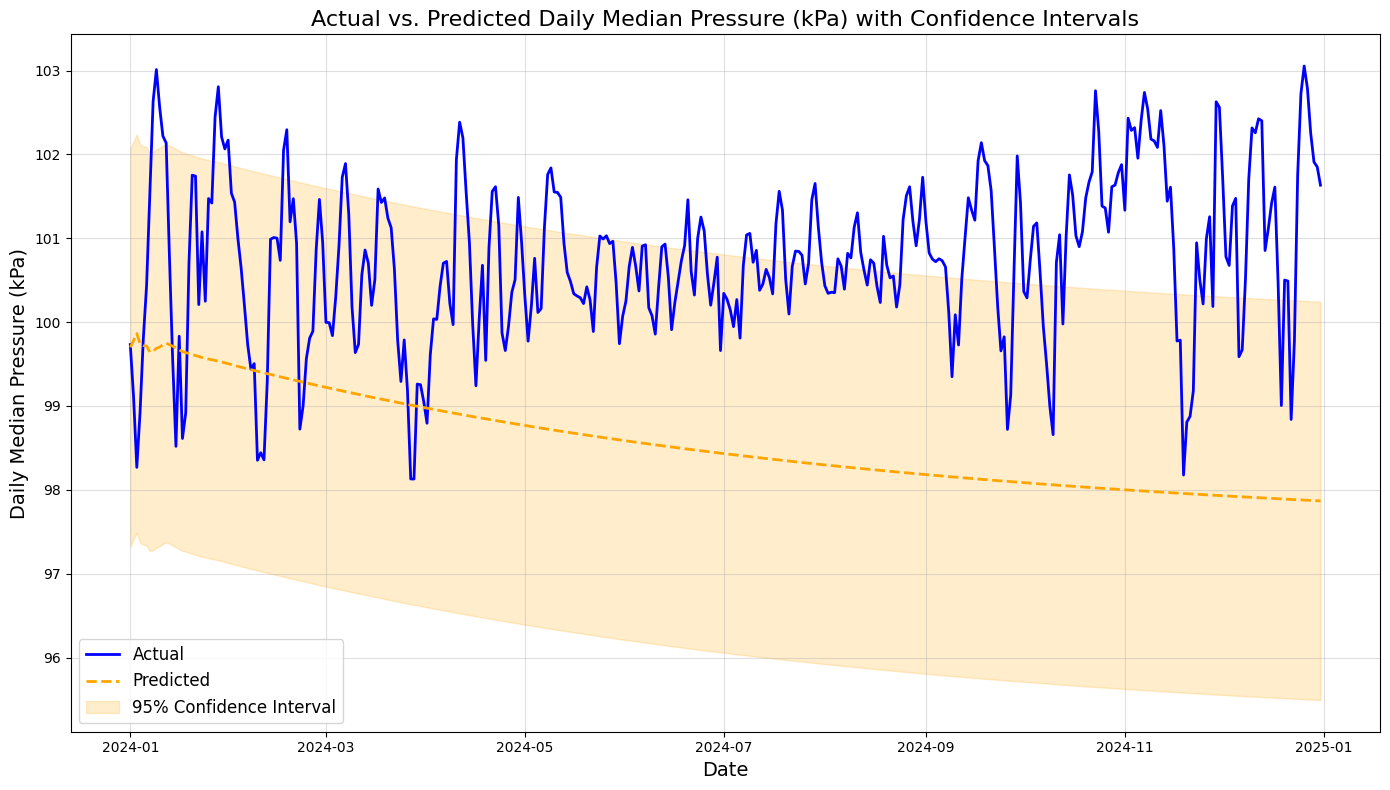

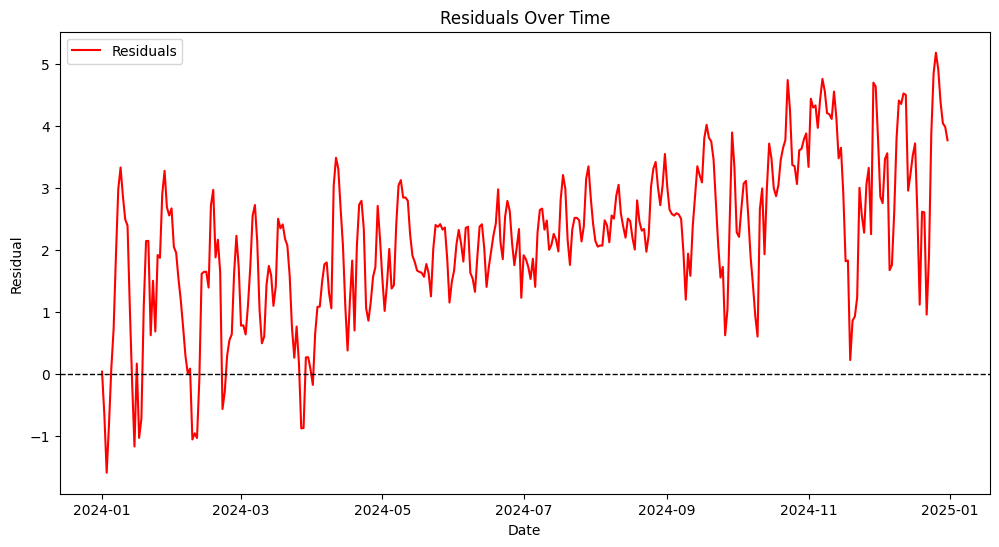

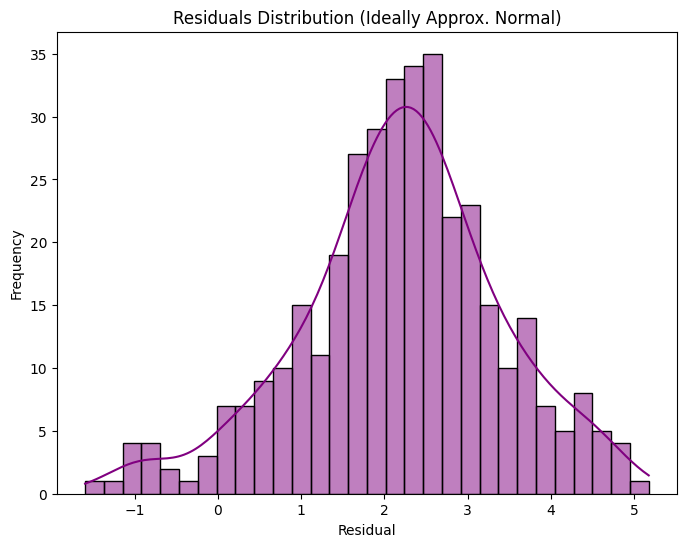

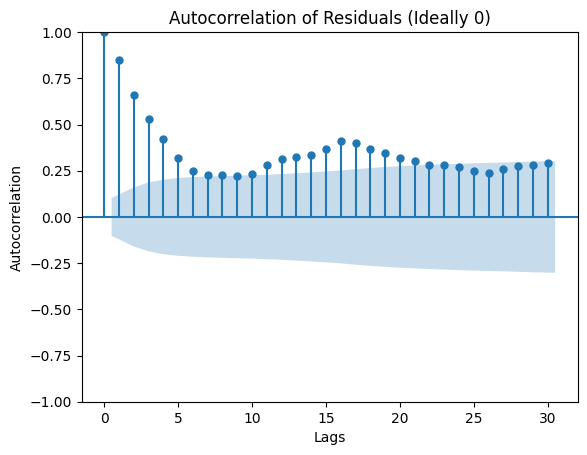

Mean Absolute Error (MAE): 2.25
Mean Squared Error (MSE): 6.23
Root Mean Squared Error (RMSE): 2.50


Forecasting of Air Quality
Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Best Lag: 19, Validation RMSE: 284464.79398437135


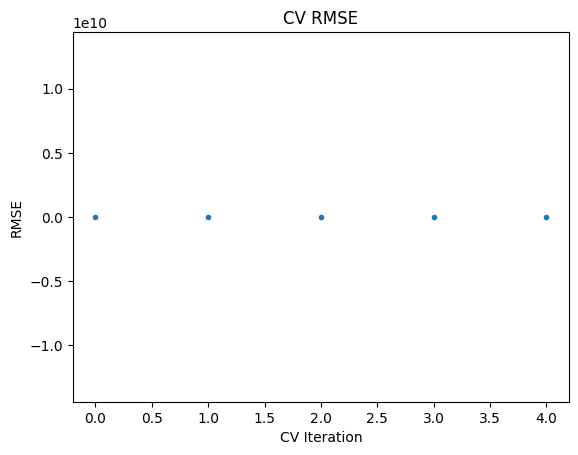

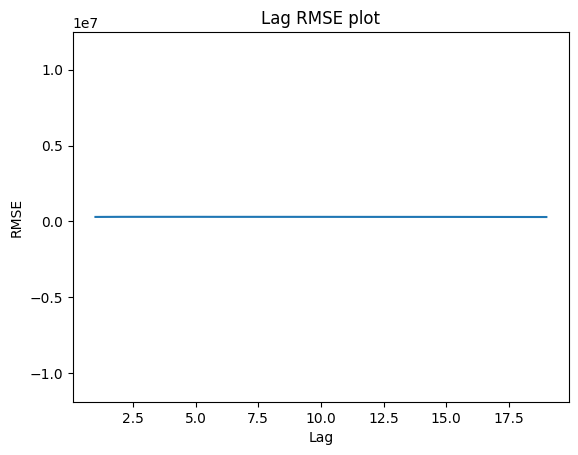

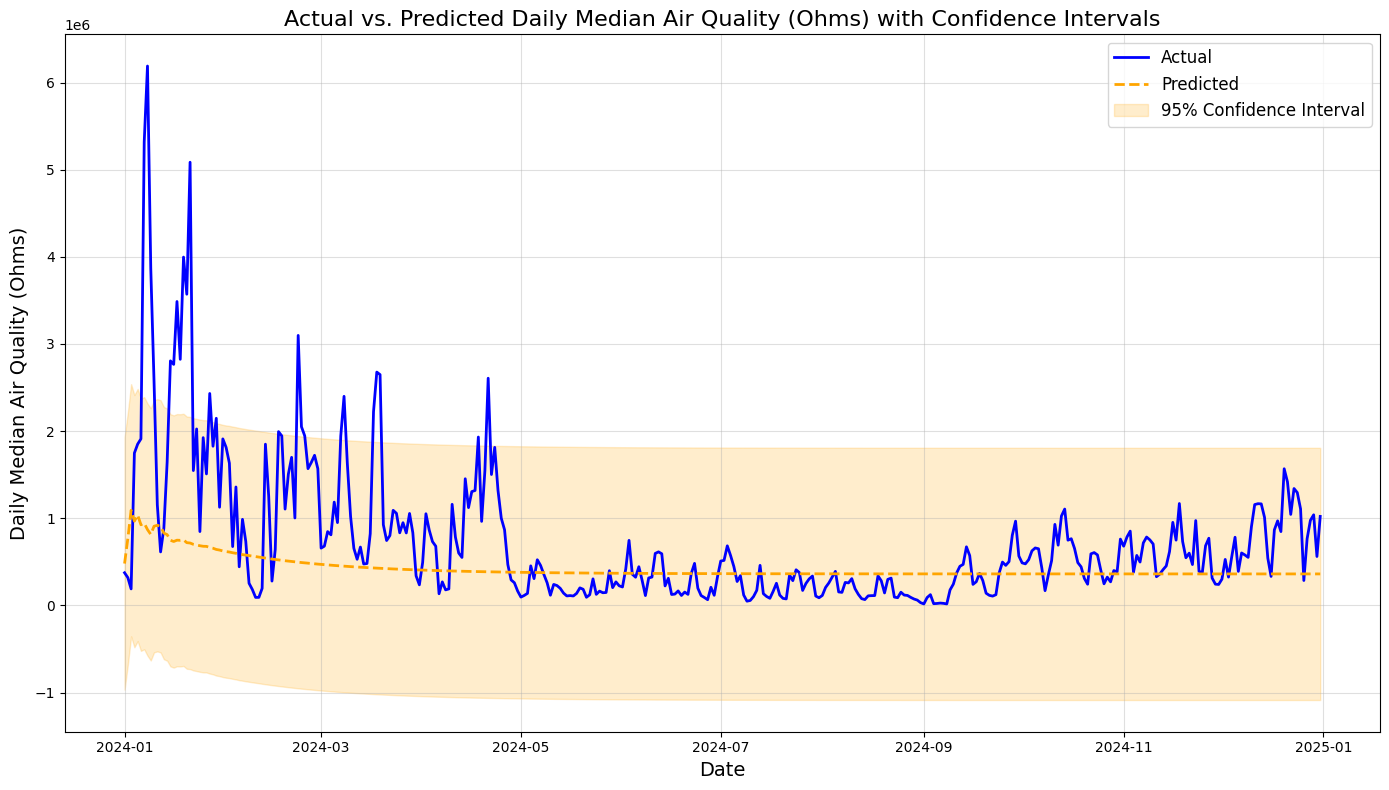

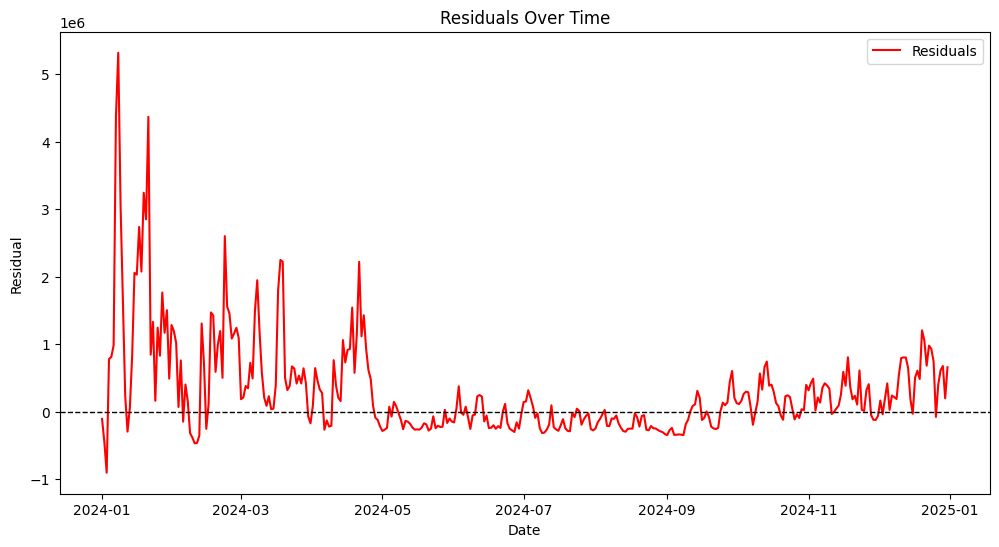

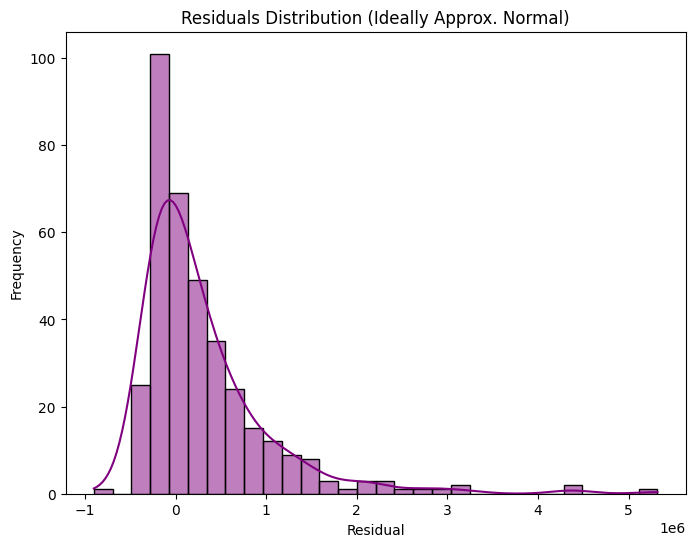

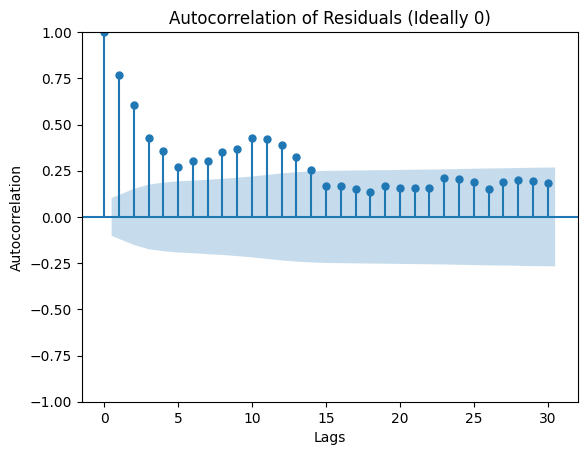

Mean Absolute Error (MAE): 467415.14
Mean Squared Error (MSE): 636009966002.27
Root Mean Squared Error (RMSE): 797502.33


In [9]:
# Evaluation of Daily Median Temperature
median_temps_train, median_temps_test = ts_train_test_split(temperature_stats['median'])
train_and_evaluate_ar_model(median_temps_train, median_temps_test, "Daily Median Temperature (C)")

# Evaluation of Daily Median Humidity
print("\n\nForecasting of Humidity")
median_humidity_train, median_humidity_test = ts_train_test_split(humidity_stats['median'])
train_and_evaluate_ar_model(median_humidity_train, median_humidity_test, "Daily Median Humidity (%)")

# Evaluation of Daily Median Pressure
print("\n\nForecasting of Pressure")
median_pressure_train, median_pressure_test = ts_train_test_split(pressure_stats['median'])
train_and_evaluate_ar_model(median_pressure_train, median_pressure_test, "Daily Median Pressure (kPa)")

# Evaluation of Median Daily Air Quality
print("\n\nForecasting of Air Quality")
median_airq_train, median_airq_test = ts_train_test_split(airq_stats['median'])
train_and_evaluate_ar_model(median_airq_train, median_airq_test, "Daily Median Air Quality (Ohms)")


## Auto Regressive Integrated Moving Average (ARIMA)

Components of ARIMA (p, q, d) Model:
- AR (p): autoregressive component, models dependency between current value and its lagged values
- MA (q): moving average component, models dependency between current value and past forecast errors
- I (d): Integration (differencing), transforms non-stationary data into stationary data by: (current - previous)

ARMA models assume the data have no trends, to ensure this assumption is valid, we test using an Augmented Dickey-Fuller (ADF) Test

ARIMA(p,q,d=0) = ARMA(p,q)

---

### Moving Average:

Definition: The current value of the time series depends on past forecast errors (white noise).

Mathematical Form:

$$X_t = c + \theta_q\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \dots + \theta_q\varepsilon_{t-q} + \varepsilon_{t}$$

Components:
- $X_t$: Current value of the series.
- $c$: Constant term
- $\theta_1,\theta_2,...,\theta_q$: Moving Average Coefficients
- $q$: Number of lagged forecast errors (order of the MA model)
- $\varepsilon_t$: *White* noise (normally distributed error)

The model corrects for past forecast errors to improve predictions

Large past errors influence current values due to weights ($\theta_i$)

e.g. Correcting for under-/over-predictions in previous days to refine the forecast

---

### Auto Regressive Moving Average (ARMA)

In tandem, the components capture the following,

AR Component: Long-term relationships and trends based on past values

MA Component: Short-term fluctuations based on past errors

Mathematical Form:

$$X_t = c + \sum_{i=1}^{p}\phi_iX_{t-i} + \sum_{j=1}^{q}\theta_j\varepsilon_{t-j} + \varepsilon_{t}$$

AR explains the underlying structure and MA adusts for residual noise



---

### Integration (differencing):

Applied to the timeseries before the ARMA model is fit and the inverse is applied after to get predictions in terms of the original time series. (e.g. post-processing with $d=1$, predicted value $y_t = y_t' + y_{t-1}$)

#### First differencing: $d = 1$ 

Essentially "takes the first derivative of the timeseries" -- removes linear trends

$y_t' = y_t - y_{t-1}$

Think of a time series that continues going up (or down) linearly


#### Second differencing: $d = 2$

Essentially "takes the second derivative of the timeseries" -- removes quadratic trends

$y_t'' = y_t' - y_{t-1}' = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$

This of a time series that goes up (or down) quadratically

#### Concerns with differencing

Under-differencing (d too low): Residuals are non stationary - poor generalization, trend left in residuals

Correct Differencing: Improves model performance (allows AR and MA terms to focus on short term dependencies)

Over-differencing (d too high): Excessive noise, unstable (highly oscilliatory predictions)

---

Rinse and Repeat

In [19]:
def train_and_evaluate_arima_model(train_data, test_data, name: str, max_p=30, max_q=30, max_d=2, num_folds=5):
    '''
    Trains, does HPO with CV, and evalutes an ARIMA timeseries model given train and test 
    Inputs:
        - train: a train timeseries compatible with TimeSeriesSplit
        - test: a test timeseries
        - name: the y-value of the time series
        - max_p: maximum p hyperparameter (number of AR terms) to try
        - max_q: maximum q hyperparameter (number of MA terms) to try
        - max_d: maximum d hyperparameter (temproal differencing) to try
        - num_folds: the number of cross validation folds to use
    Outputs:
        - Test MAE
        - Test MSE
        - Test RMSE
    Postconditions:
        - The best hyperparameter MSE plot is plotted
        - evaluate_ts_predictions is called & plots are produced
    '''
    # Time series cross validation 
    tscv = TimeSeriesSplit(n_splits = num_folds)

    # Hyperparameters
    p_range = range(1, max_p+1)
    d_range = range(0, max_d+1)
    q_range = range(1, max_q+1)
    
    # Evaluation function
    def get_val_loss_from_arima(train, val, p, d, q):
        '''Train and get validation loss for an ARIMA(p,d,q) model'''
        model = ARIMA(train, order=(p,d,q)).fit()
        predictions = model.forecast(steps=len(val))
        loss = np.mean((predictions - val)**2)
        return loss

    # Store cross-validation losses
    cv_results =[]

    # HPO CV Loop
    for p in p_range:
        for d in d_range:
            for q in q_range:
                losses = []
                print(f"Hyperparameters: p-{p} d-{d} q-{q}")
                for train_index, val_index in tscv.split(train_data):
                    train_split, val_split = train_data.iloc[train_index], train_data.iloc[val_index]
                    loss = get_val_loss_from_arima(train_split, val_split, p, d, q)
                    losses.append(loss)
                mean_loss = np.mean(losses)
                cv_results.append((p, d, q, mean_loss))

    # Find the best hyperparameters
    print(cv_results)
    best_p, best_d, best_q, best_loss = min(cv_results, key=lambda x: x[3])
    print(f"Best ARIMA({best_p}, {best_d}, {best_q}) with CV Loss: {best_loss:.4f}")

    # Train and evaluate final model
    final_model = ARIMA(train_data, order=(best_p, best_d, best_q)).fit()
    test_predictions = final_model.forecast(steps=len(test_data))
    evaluate_ts_predictions(test_data, test_predictions, name)



#### Use of ARIMA model on Daily Median Weather Data

Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Hyperparameters: p-1 d-0 q-1
Hyperparameters: p-1 d-0 q-2
Hyperparameters: p-1 d-0 q-3
Hyperparameters: p-1 d-0 q-4
Hyperparameters: p-1 d-0 q-5
Hyperparameters: p-2 d-0 q-1


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h

Hyperparameters: p-2 d-0 q-2


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h

Hyperparameters: p-2 d-0 q-3


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-2 d-0 q-4


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-2 d-0 q-5
Hyperparameters: p-3 d-0 q-1
Hyperparameters: p-3 d-0 q-2


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chand

Hyperparameters: p-3 d-0 q-3


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-3 d-0 q-4


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-3 d-0 q-5


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packa

Hyperparameters: p-4 d-0 q-1
Hyperparameters: p-4 d-0 q-2


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/s

Hyperparameters: p-4 d-0 q-3


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-4 d-0 q-4


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/states

Hyperparameters: p-4 d-0 q-5


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/s

Hyperparameters: p-5 d-0 q-1


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-5 d-0 q-2


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packa

Hyperparameters: p-5 d-0 q-3


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/s

Hyperparameters: p-5 d-0 q-4


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model

Hyperparameters: p-5 d-0 q-5


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandler/.local/lib/python3.8/s

Best ARIMA(3, 0, 2) with CV Loss: 50.9940


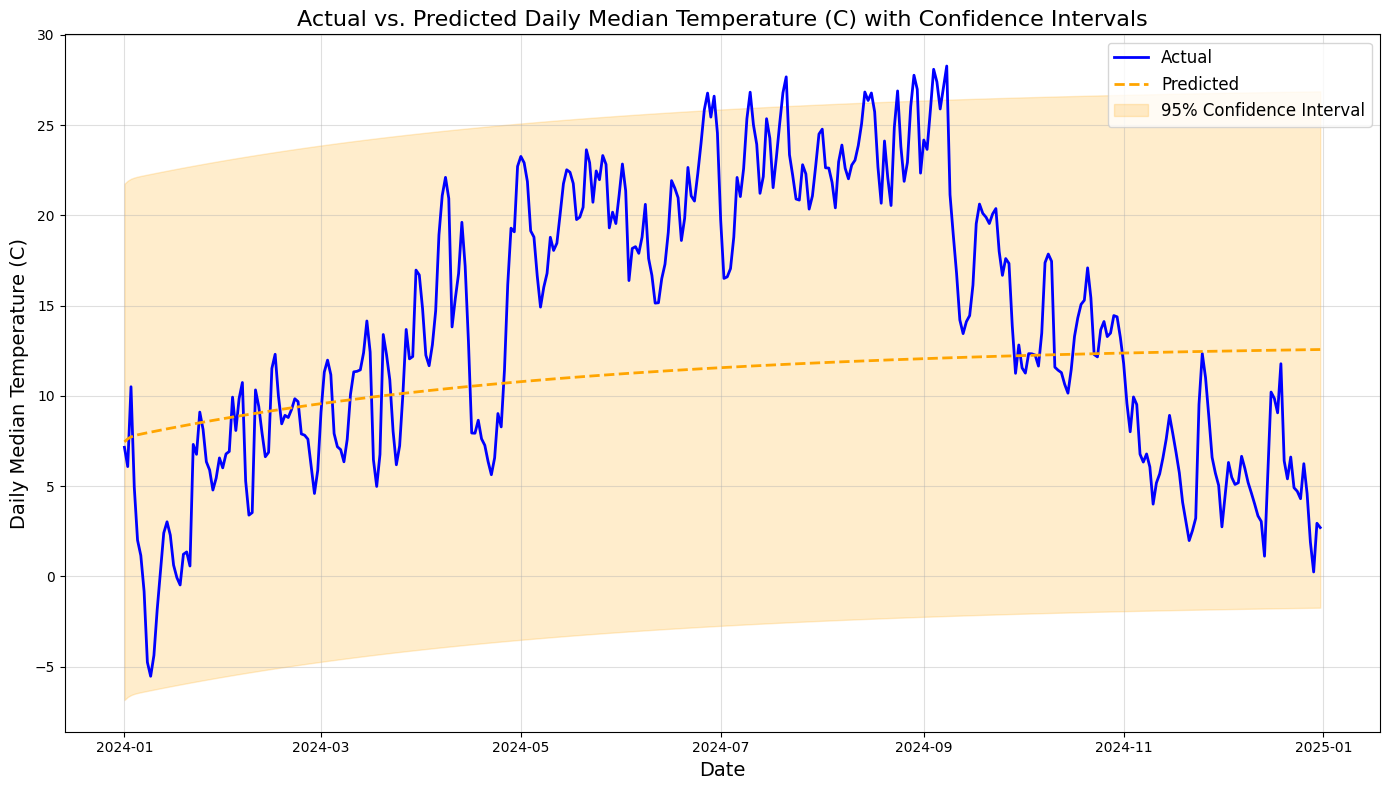

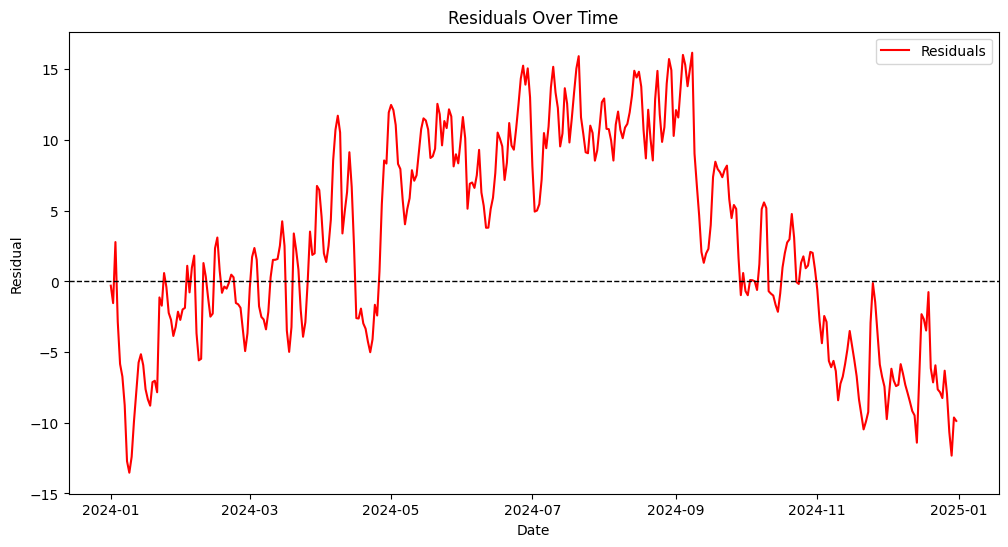

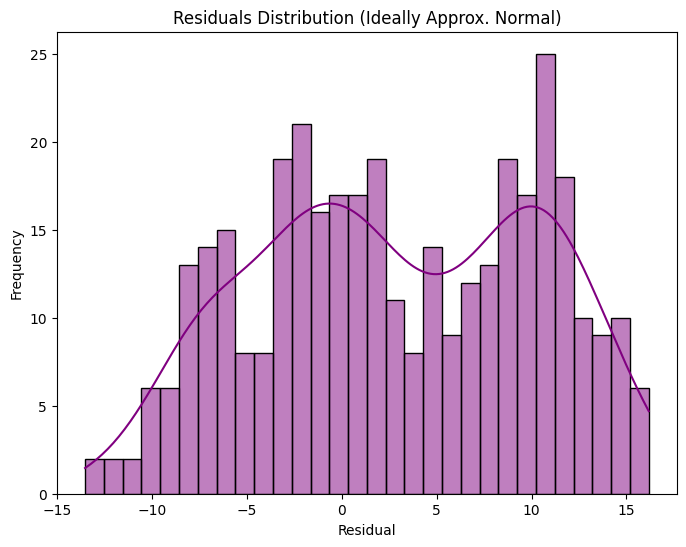

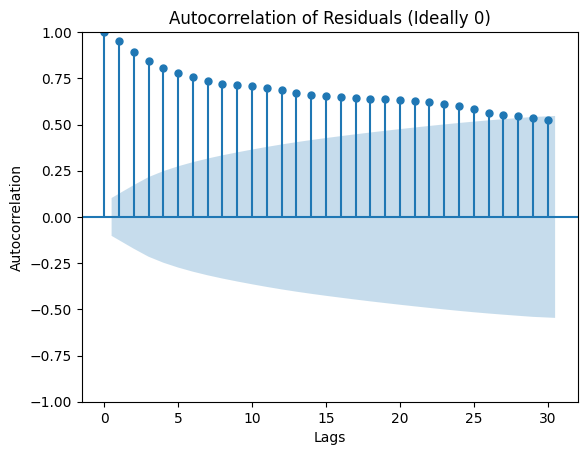

Mean Absolute Error (MAE): 6.55
Mean Squared Error (MSE): 61.21
Root Mean Squared Error (RMSE): 7.82


Forecasting of Humidity
Training data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Test data period: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Hyperparameters: p-1 d-0 q-1
Hyperparameters: p-1 d-0 q-2
Hyperparameters: p-1 d-0 q-3


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyperparameters: p-1 d-0 q-4


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-5


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-6


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-7


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-8


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-9


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hyperparameters: p-1 d-0 q-10


/home/chandler/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chandler/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [18]:
# Evaluation of Daily Median Temperature
median_temps_train, median_temps_test = ts_train_test_split(temperature_stats['median'])
train_and_evaluate_arima_model(median_temps_train, median_temps_test, "Daily Median Temperature (C)")

# Evaluation of Daily Median Humidity
print("\n\nForecasting of Humidity")
median_humidity_train, median_humidity_test = ts_train_test_split(humidity_stats['median'])
train_and_evaluate_arima_model(median_humidity_train, median_humidity_test, "Daily Median Humidity (%)")

# Evaluation of Daily Median Pressure
print("\n\nForecasting of Pressure")
median_pressure_train, median_pressure_test = ts_train_test_split(pressure_stats['median'])
train_and_evaluate_arima_model(median_pressure_train, median_pressure_test, "Daily Median Pressure (kPa)")

# Evaluation of Median Daily Air Quality
print("\n\nForecasting of Air Quality")
median_airq_train, median_airq_test = ts_train_test_split(airq_stats['median'])
train_and_evaluate_arima_model(median_airq_train, median_airq_test, "Daily Median Air Quality (Ohms)")

## Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [ ]:
def train_and_evaluate_sarima_model(train_data, test_data, m, max_P, max_Q, max_D, name: str, max_p=30, max_q=30, max_d=2, num_folds=5):
    """
    Explore SARIMA models using hyperparameter optimization, cross-validation, and evaluation.

    Parameters:
    - train_data (pd.Series): Training time series data.
    - test_data (pd.Series): Test time series data.
    - p_values, d_values, q_values: Lists of non-seasonal ARIMA parameters.
    - P_values, D_values, Q_values: Lists of seasonal ARIMA parameters.
    - m (int): Seasonal period (e.g., 12 for monthly data).
    """

    tscv = TimeSeriesSplit(n_splits=num_folds)